# Los Datos <a class="anchor" id="losdatos"></a>

MNIST es una base de datos con 70 mil capturas de dígitos escritos a mano, del 0 al 9.  La misma fue creada en su momento por empleados del *US Census Bureau* de Estados Unidos y por estudiantes con el objetivo de crear un sistema capaz de reconocer los números de los códigos postales.   

La gente de Scikit-Learn guarda una versión a la cual podemos acceder libremente.

**Segunda Parte**:  

Esta segunda parte es similar a la primera pero incluye elementos vistos en la materia **Práctica Profesionalizante 3** y se utilizará para evaluar dicha materia.  

Luego de observar las imágenes, Ud supone que algunos pixels de la misma tienen poca relevancia para determinar qué número está escrito en ellas. 

1- Con los métodos vistos en PP3 (esencialmente filtros) deberá generar un conjunto de **a lo sumo 200 pixels** con los cuales deberá repetir la primera parte.  
2- Al modelo de producción de esta segunda parte deberá llamarlo **produccion_2**  
3- Deberá comparar los resultados obtenidos con los anteriores y anotar cómo funciona mejor.   
4- Finalmente con produccion_2 deberá etiquetar las 10 mil imágenes y guardar las etiquetas como *suApellido_2.npy*  

Nota: Debe documentar su trabajo para luego poder explicarlo, no genere código sin explicaciones!

##### Para realizar la tarea de seleccion de features, vamos a utilizar el F-test Anova entre cada pixel y la variable target, para comprobar que existe una relacion entre estas, es decir, nuestras Xs, explican nuestras Ys. Este test es el adecuado debido a que poseemos features continuas y target categorico en nuestro problema

### Con cuantas variables tendriamos un nivel de accuracy aceptable? Veamos que obtenemos al respecto

Haremos la prueba con decision tree porque funciona rapido, asi probaremos para determinadas cantidades de parametros, cuando accuracy vamos obteniendo, para determinar un buen numero para entrenar

In [2]:
import numpy as np
import pandas as pd
X_train=np.load('Alumno/X_MNIST_60_mil.npy', allow_pickle=True)
y_train=np.load('Alumno/Y_MNIST_60_mil.npy', allow_pickle=True)
X_test=np.load('Alumno/X_MNIST_10_mil.npy', allow_pickle=True)
#y_test se lo guardo el profe

In [77]:
X_train.shape

(60000, 784)

In [78]:
X_test.shape

(10000, 784)

In [79]:
y_train.shape

(60000,)

In [80]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [81]:
from sklearn.model_selection import train_test_split

X_val_train,X_val_test,y_val_train,y_val_test=train_test_split(X_train,y_train,test_size=0.2,random_state=123)

In [82]:
X_val_train = X_val_train.to_numpy()

In [83]:
X_val_test = X_val_test.to_numpy()

In [84]:
from sklearn.feature_selection import f_classif

f = f_classif(X_train, y_train)[0]

C:\Users\Mateio\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  0   1   2   3   4   5   6   7   8   9  10  11  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  52  53  54  55  56  57
  82  83  84  85 111 112 140 168 392 476 560 644 671 672 673 699 700 701
 727 728 729 730 753 754 755 756 757 758 759 780 781 782 783] are constant.
  UserWarning)
C:\Users\Mateio\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [85]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_train, y_train)

El siguiente codigo entrenara y evaluara modelos entrenados segun distintos valores de K top variables, elegidas con ANOVA y mutual information, con el objetivo de realizar un grafico que nos permita ver en que momento la ganancia de informacion se estabiliza. De esta forma, podremos entrenar con ese numero de parametros y no todos los disponibles, porque ya sabemos de antemano que, por ejemplo, las esquinas de las imagenes, son una constante, dado que por la naturaleza del problema, los numeros no estan presentes en ese lugar.

In [86]:
import numpy as np

ranking = pd.DataFrame(index = range(X_val_train.shape[1]))

ranking['f'] = pd.Series(f, index = ranking.index).fillna(0).rank(ascending = False)
ranking['mi'] = pd.Series(mi, index = ranking.index).fillna(0).rank(ascending = False)

ranking = ranking.replace(to_replace = ranking.max(), value = X_val_train.shape[1])
ranking.to_csv('ranking.csv', index = False)

In [87]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
algos = ['f','mi']
ks = [20,40,80,120,160,200,300,400]

accuracy = pd.DataFrame(index = ks, columns = algos)

for algo in algos:
    
    for k in ks:
    
        cols = ranking[algo].sort_values().head(k).index.to_list()
                
        clf = DecisionTreeClassifier().fit(
            X_val_train[:, cols], y_val_train)
                
        accuracy.loc[k, algo] = accuracy_score(
            y_true = y_val_test, y_pred = clf.predict(X_val_test[:, cols]))
        
accuracy.to_csv('accuracy.csv', index = True)

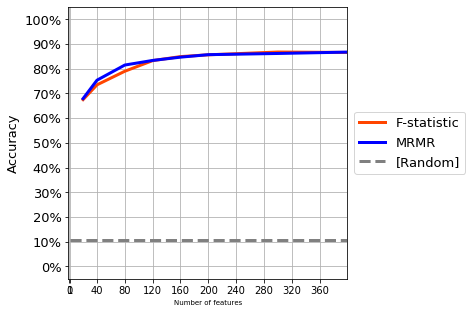

In [89]:
for algo, label, color in zip(
    ['f','mi'],
    ['F-statistic','MRMR'],
    ['orangered','blue']):
        plt.plot(accuracy.index, accuracy[algo], label = label, color = color, lw = 3)

plt.plot(
    [1, 400], [pd.Series(y_val_test).value_counts(normalize = True).iloc[0]] * 2, 
    label = '[Random]', color = 'grey', ls = '--', lw = 3
)

plt.legend(fontsize = 13, loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.grid()
plt.yticks(np.linspace(0, 1, 11), ['{:.0%}'.format(i) for i in np.linspace(0, 1, 11)], fontsize = 13)
plt.xticks([1] + list(range(0, 400, 40)), fontsize = 10)
plt.xlim(-1, 400)
plt.ylim(-.05, 1.05)
plt.xlabel('Number of features', fontsize = 7)
plt.ylabel('Accuracy', fontsize = 13)
plt.savefig('accuracy.png', dpi = 300, bbox_inches = 'tight')

#### Conclusiones: con 200 variables, tanto por el metodo de ANOVA como Mutual Information, podemos ver que el accuracy del modelo se estabiliza, entonces, entrenamos con esta cantidad.

### Modelizacion post feature selection

Cambiar el K, determinando con que top de variables queremos quedarnos

In [116]:
import numpy as np
import pandas as pd
X_train=np.load('Alumno/X_MNIST_60_mil.npy', allow_pickle=True)
y_train=np.load('Alumno/Y_MNIST_60_mil.npy', allow_pickle=True)
X_test=np.load('Alumno/X_MNIST_10_mil.npy', allow_pickle=True)
#y_test se lo guardo el profe

In [3]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [4]:
K = 196

In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(score_func=f_classif, k=K)

selector.fit(X_train, y_train)

vector_names = list(X_train.columns[selector.get_support(indices=True)])
print(vector_names)

[98, 99, 100, 101, 102, 125, 126, 127, 128, 150, 151, 152, 153, 154, 155, 156, 157, 178, 179, 180, 181, 182, 183, 184, 185, 236, 262, 263, 264, 267, 270, 271, 272, 289, 290, 291, 295, 298, 299, 300, 301, 302, 316, 317, 318, 319, 322, 323, 325, 326, 327, 329, 330, 331, 344, 345, 346, 347, 348, 349, 350, 351, 353, 354, 357, 358, 359, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 385, 386, 387, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 412, 413, 414, 415, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 440, 441, 442, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 468, 469, 470, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 495, 496, 497, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 522, 523, 524, 538, 539, 540, 541, 542, 543, 544, 545, 550, 551, 552, 566, 567, 568, 569, 570, 571, 572, 577, 578, 594, 595, 596, 597, 598, 623, 624, 625, 626, 627, 628, 654, 655, 656, 657, 658, 711, 712, 713]


C:\Users\Mateio\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  0   1   2   3   4   5   6   7   8   9  10  11  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  52  53  54  55  56  57
  82  83  84  85 111 112 140 168 392 476 560 644 671 672 673 699 700 701
 727 728 729 730 753 754 755 756 757 758 759 780 781 782 783] are constant.
  UserWarning)
C:\Users\Mateio\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Creo dataframe con los promedios para luego asignar un color

In [7]:
promedios = np.mean(X_train)
promedios = pd.DataFrame(promedios,columns=['Promedio'])
promedios

,Promedio
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
779,0.000967
780,0.000000
781,0.000000
782,0.000000


In [8]:
promedios[~promedios.index.isin(vector_names)] = 0  #Accedo a las features que no estaban entre las elegidas y les doy el valor 0
promedios[promedios.index.isin(vector_names)] = 255 #Accedo a las que si estaban seleccionadas y les doy valor 255

In [9]:
promedios = promedios.to_numpy() #Convierto a numpy array

In [10]:
promedios = promedios.reshape(28,28) #Le doy formato de imagen 28x28

La imagen se debe interpretar como top K pixeles que explican que una observacion (una imagen) sea alguna de las posibilidades de y

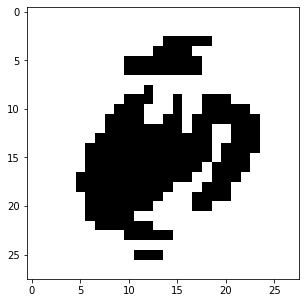

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
plt.imshow(promedios, cmap='binary', vmin=0, vmax=255) 
plt.show()

### Modelizacion con el nuevo dataframe reducido

Obtengo los dataframes para entrenar los nuevos modelos y chequeo que tengan el tamaño deseado

In [6]:
X_train_best = X_train[vector_names]
X_test_best = X_test[vector_names]

print(X_train_best.shape)
print(X_test_best.shape)

(60000, 196)
(10000, 196)


In [7]:
X_train_best = X_train_best / 255
X_test_best = X_test_best / 255

In [8]:
from sklearn.model_selection import train_test_split
X_val_train,X_val_test,y_val_train,y_val_test=train_test_split(X_train_best,y_train,test_size=0.2,random_state=123)

## Modelizacion clasica con GridSearchCV - Tuning de hiperparametros

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

### Modelización Regresión Logística Ridge <a class="anchor" id="GS-RL"></a>

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
# Creamos el modelo con los parámetros que no cambiarán, observe que no le pasamos el valor de C de regulrización
Log_Ridge=LogisticRegression(penalty='l2', max_iter=10000, tol=0.0001) 

# Armamos el diccionario con el  nombre y valores para los Hiperparámetros
parametros_RL = {'C':[0.01,0.1,1,10,100]}   

# Armamos el GridSearchCV
grid_RL = GridSearchCV(estimator = Log_Ridge,param_grid = parametros_RL,scoring = 'accuracy', cv = 3, verbose = 1,
                        n_jobs = -1)

# Lo entrenamos en el Train Set (él lo dividirá internamente y en cada fold estarán en ValTrain y ValTest)
grid_RL.fit(X_val_train, y_val_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.5min finished


In [20]:
# Obtenemos el mejor AC 
AC_RL_best=grid_RL.best_score_
AC_RL_best

0.8580208333333333

In [21]:
#Mejor regularizacion C
parametros_RL_best=grid_RL.best_params_
parametros_RL_best

{'C': 100}

In [22]:
#Mejor modelo RL
modelo_RL_best=grid_RL.best_estimator_
modelo_RL_best

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
# Podemos calcular el desvío standard para el mejor caso:
desvios_RL = grid_RL.cv_results_['std_test_score'] 
desvio_mejor_RL=desvios_RL[grid_RL.best_index_]
desvio_mejor_RL

0.003808342450754952

In [24]:
print("Modelo de Regresión Logística  con Regularización Ridge")

print("Mejor Accuracy: ",round(AC_RL_best,3),' +/- ', round(2*desvio_mejor_RL,3), '( 95% )')

print("Lectura del intervalo: Con un 95% de confianza, podemos decir que el modelo clasificará correctamente en producción entre el: ",round(AC_RL_best - desvio_mejor_RL,2)*100,'% y el ',round(AC_RL_best + 2*desvio_mejor_RL,2)*100 , '% de las observaciones')

Modelo de Regresión Logística  con Regularización Ridge
Mejor Accuracy:  0.858  +/-  0.008 ( 95% )
Lectura del intervalo: Con un 95% de confianza, podemos decir que el modelo clasificará correctamente en producción entre el:  85.0 % y el  87.0 % de las observaciones


### Modelización kNN  <a class="anchor" id="GS-kNN"></a>

In [25]:
from sklearn import neighbors 
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

import warnings
warnings.simplefilter('ignore')

print("Evaluación modelo kNN en el Validation")

# Creamos el modelo con los parámetros que no cambiarán, observe que no le pasamos el valor de C de regulrización
kNN=neighbors.KNeighborsClassifier()

# Armamos el diccionario con el  nombre y valores para los Hiperparámetros
parametros_kNN = {'n_neighbors':np.arange(2,5,1),'weights':['uniform','distance']}

# Armamos el GridSearchCV
grid_kNN = GridSearchCV(estimator = kNN,param_grid = parametros_kNN,scoring = 'accuracy', cv = 3, verbose = 1,
                        n_jobs = -1)

# Lo entrenamos en el Train Set (él lo dividirá internamente y en cada fold estarán en ValTrain y ValTest)
grid_kNN.fit(X_val_train, y_val_train);

Evaluación modelo kNN en el Validation
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 37.3min finished


In [26]:
# Obtenemos el mejor AC 
AC_kNN_best=grid_kNN.best_score_
AC_kNN_best

0.9551041666666666

In [27]:
parametros_kNN_best=grid_kNN.best_params_
parametros_kNN_best

{'n_neighbors': 4, 'weights': 'distance'}

In [28]:
modelo_RL_best=grid_kNN.best_estimator_
modelo_RL_best

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [29]:
# Podemos calcular el desvío standard para el mejor caso:
desvios_kNN = grid_kNN.cv_results_['std_test_score'] 
desvio_mejor_kNN=desvios_kNN[grid_kNN.best_index_]
desvio_mejor_kNN

0.0012250992023324588

In [30]:
print("Modelo de kNN")

print("Mejor Accuracy: ",round(AC_kNN_best,3),' +/- ', round(2*desvio_mejor_kNN,3), '( 95% )')

print("Lectura del intervalo: Con un 95% de confianza, podemos decir que el modelo clasificará correctamente en producción entre el: ",round(AC_kNN_best - desvio_mejor_kNN,2)*100,'% y el ',round(AC_kNN_best + 2*desvio_mejor_kNN,2)*100 , '% de las observaciones')

Modelo de kNN
Mejor Accuracy:  0.955  +/-  0.002 ( 95% )
Lectura del intervalo: Con un 95% de confianza, podemos decir que el modelo clasificará correctamente en producción entre el:  85.0 % y el  87.0 % de las observaciones


### Modelización Arbol  <a class="anchor" id="GS-DT"></a>

In [31]:
from sklearn.tree import DecisionTreeClassifier 

In [32]:
parametros_arbol = {'max_depth':np.arange(1,20,4)}
arbol=DecisionTreeClassifier(random_state=123)  # para que sea repetible
grid_arbol = GridSearchCV(estimator = arbol,param_grid = parametros_arbol,scoring = 'accuracy', cv = 3, verbose = 1,n_jobs = -1)
grid_arbol.fit(X_val_train, y_val_train);   # el ";" al final es para que no muestre toodos los parámetros que va a usar.

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   26.9s finished


In [33]:
AC_arbol_best=grid_arbol.best_score_
AC_arbol_best

0.844875

In [34]:
parametros_arbol_best=grid_arbol.best_params_
parametros_arbol_best

{'max_depth': 13}

In [35]:
modelo_arbol_best=grid_arbol.best_estimator_
modelo_arbol_best

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=13, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [36]:
desvios_arbol=grid_arbol.cv_results_['std_test_score']
desvios_arbol

array([0.00281659, 0.0087971 , 0.00483235, 0.00413099, 0.00381335])

In [37]:
desvio_arbol_mejor=desvios_arbol[grid_arbol.best_index_] #Obtengo el desvío del mejor arbol

In [38]:
print("Modelo de Árbol")

print("Mejor Accuracy: ",round(AC_arbol_best,3),' +/- ', round(2*desvio_arbol_mejor,3), '( 95% )')

print("Lectura del intervalo: Con un 95% de confianza, podemos decir que el modelo clasificará correctamente en producción entre el: ",round(AC_arbol_best - desvio_arbol_mejor,2)*100,'% y el ',round(AC_arbol_best + 2*desvio_arbol_mejor,2)*100 , '% de las observaciones')

Modelo de Árbol
Mejor Accuracy:  0.845  +/-  0.008 ( 95% )
Lectura del intervalo: Con un 95% de confianza, podemos decir que el modelo clasificará correctamente en producción entre el:  84.0 % y el  85.0 % de las observaciones


### Modelización SVM  <a class="anchor" id="GS-SVM"></a>

In [39]:
from sklearn.svm import LinearSVC

In [40]:
parametros_SVM = {'C': [0.1, 10, 1000]} 

SVM = LinearSVC(loss="hinge", multi_class='ovr')

grid_SVM = GridSearchCV(estimator= SVM, param_grid = parametros_SVM, scoring = 'accuracy', cv = 3, verbose = 1, n_jobs = -1) 
  
# fitting the model for grid search 
grid_SVM.fit(X_val_train, y_val_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='hinge', max_iter=1000, multi_class='ovr',
                                 penalty='l2', random_state=None, tol=0.0001,
                                 verbose=0),
             iid='deprecated', n_jobs=-1, param_grid={'C': [0.1, 10, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [41]:
AC_SVM_best=grid_SVM.best_score_
AC_SVM_best

0.8720833333333333

In [42]:
parametros_SVM_best=grid_SVM.best_params_
parametros_SVM_best

{'C': 1000}

In [43]:
modelo_SVM_best=grid_SVM.best_estimator_
modelo_SVM_best

LinearSVC(C=1000, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [44]:
desvios_SVM=grid_SVM.cv_results_['std_test_score']
desvios_SVM

array([0.0016591 , 0.00190189, 0.00317966])

In [45]:
desvio_SVM_mejor=desvios_SVM[grid_SVM.best_index_] #Obtengo el desvío del mejor arbol

In [46]:
print("Modelo SVM")

print("Mejor Accuracy: ",round(AC_SVM_best,3),' +/- ', round(2*desvio_SVM_mejor,3), '( 95% )')

print("Lectura del intervalo: Con un 95% de confianza, podemos decir que el modelo clasificará correctamente en producción entre el: ",round(AC_SVM_best - desvio_SVM_mejor,2)*100,'% y el ',round(AC_SVM_best + 2*desvio_SVM_mejor,2)*100 , '% de las observaciones')

Modelo SVM
Mejor Accuracy:  0.872  +/-  0.006 ( 95% )
Lectura del intervalo: Con un 95% de confianza, podemos decir que el modelo clasificará correctamente en producción entre el:  87.0 % y el  88.0 % de las observaciones


### Modelización Elastic Net  <a class="anchor" id="GS-EN"></a>

In [47]:
from sklearn.linear_model import SGDClassifier

In [48]:
parametros_EN = {"alpha": [0.1, 1, 10],"l1_ratio": np.arange(0.0, 1.0, 0.2)}

EN = SGDClassifier(loss='log', penalty='elasticnet')

grid_EN = GridSearchCV(estimator= EN, param_grid = parametros_EN, scoring = 'accuracy', cv = 3, verbose = 1, n_jobs = -1) 
  
# fitting the model for grid search 
grid_EN.fit(X_val_train, y_val_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='elasticnet', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 10],
                         'l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
         

In [49]:
AC_EN_best=grid_EN.best_score_
AC_EN_best

0.11214583333333333

In [50]:
parametros_EN_best=grid_EN.best_params_
parametros_EN_best

{'alpha': 0.1, 'l1_ratio': 0.0}

In [51]:
modelo_EN_best=grid_EN.best_estimator_
modelo_EN_best

SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.0,
              learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [52]:
desvios_EN=grid_EN.cv_results_['std_test_score']

In [53]:
desvio_EN_mejor=desvios_EN[grid_EN.best_index_] #Obtengo el desvío del mejor

In [54]:
print("Modelo Regresion Logistica con Elastic Net")

print("Mejor Accuracy: ",round(AC_EN_best,3),' +/- ', round(2*desvio_EN_mejor,3), '( 95% )')

print("Lectura del intervalo: Con un 95% de confianza, podemos decir que el modelo clasificará correctamente en producción entre el: ",round(AC_EN_best - desvio_EN_mejor,2)*100,'% y el ',round(AC_EN_best + 2*desvio_EN_mejor,2)*100 , '% de las observaciones')

Modelo Regresion Logistica con Elastic Net
Mejor Accuracy:  0.112  +/-  0.0 ( 95% )
Lectura del intervalo: Con un 95% de confianza, podemos decir que el modelo clasificará correctamente en producción entre el:  11.0 % y el  11.0 % de las observaciones


### Random Forest  <a class="anchor" id="GS-RF"></a>

In [55]:
from sklearn.ensemble import RandomForestClassifier

parametros_RF = {"criterion": ['gini', 'entropy'],"n_estimators": np.arange(0, 1000, 100)}

RF = RandomForestClassifier()

grid_RF = GridSearchCV(estimator= RF, param_grid = parametros_RF, scoring = 'accuracy', cv = 3, verbose = 1, n_jobs = -1) 
  
# fitting the model for grid search 
grid_RF.fit(X_val_train, y_val_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 64.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [56]:
AC_RF_best=grid_RF.best_score_
AC_RF_best

0.9546875

In [57]:
parametros_RF_best=grid_RF.best_params_
parametros_RF_best

{'criterion': 'gini', 'n_estimators': 700}

In [58]:
modelo_RF_best=grid_RF.best_estimator_
modelo_RF_best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [59]:
desvios_RF=grid_RF.cv_results_['std_test_score']

In [60]:
desvio_RF_mejor=desvios_RF[grid_RF.best_index_] #Obtengo el desvío del mejor

In [61]:
print("Modelo Random Forest")

print("Mejor Accuracy: ",round(AC_RF_best,3),' +/- ', round(2*desvio_RF_mejor,3), '( 95% )')

print("Lectura del intervalo: Con un 95% de confianza, podemos decir que el modelo clasificará correctamente en producción entre el: ",round(AC_RF_best - desvio_RF_mejor,2)*100,'% y el ',round(AC_RF_best + 2*desvio_RF_mejor,2)*100 , '% de las observaciones')

Modelo Random Forest
Mejor Accuracy:  0.955  +/-  0.004 ( 95% )
Lectura del intervalo: Con un 95% de confianza, podemos decir que el modelo clasificará correctamente en producción entre el:  95.0 % y el  96.0 % de las observaciones


### Conclusiones de seleccion de hiperparametros  <a class="anchor" id="Conclu-tuning"></a>

In [62]:
#Creo DataFrame con los valores obtenidos de cada modelo
dfRtdos= pd.DataFrame({'Modelo': ['Reg_Log_Ridge', 'kNN', 'Arbol','SVM', 'ElasticNet','Random Forest'],
                       'Accuracy': [AC_RL_best, AC_kNN_best,AC_arbol_best, AC_SVM_best,AC_EN_best,AC_RF_best],
                       'Hiperparametros': [parametros_RL_best , parametros_kNN_best, parametros_arbol_best, parametros_SVM_best, parametros_EN_best, parametros_RF_best]})
#Pongo los modelos como indice
dfRtdos = dfRtdos.set_index('Modelo').sort_values(['Accuracy'], ascending=False)
dfRtdos

,Accuracy,Hiperparametros
Modelo,,
kNN,0.955104,"{'n_neighbors': 4, 'weights': 'distance'}"
Random Forest,0.954688,"{'criterion': 'gini', 'n_estimators': 700}"
SVM,0.872083,{'C': 1000}
Reg_Log_Ridge,0.858021,{'C': 100}
Arbol,0.844875,{'max_depth': 13}
ElasticNet,0.112146,"{'alpha': 0.1, 'l1_ratio': 0.0}"


### Entrenar el modelo con todos los datos de train (X_val_train, y_val_Train) y evaluar modelos con datos nunca vistos: el set de testeo (X_val_test, y_val_test)  <a class="anchor" id="SeleccionModelo-ML"></a>  <a class="anchor" id="Entrenamiento-ML"></a>

#### Regresion Logistica con Ridge  <a class="anchor" id="TR-RL"></a>

In [63]:
modelo_elegido=LogisticRegression(penalty='l2', max_iter=10000, tol=0.0001, C=100) # observe el valor de C
modelo_elegido.fit(X_val_train, y_val_train)  # Entrenamos con .fit
AC_rl=modelo_elegido.score(X_val_test, y_val_test)  # calculamos Accuracy
AC_rl

0.86925

#### Decision Tree  <a class="anchor" id="TR-DT"></a>

In [64]:
modelo_elegido=DecisionTreeClassifier(max_depth=13, random_state=123)
modelo_elegido.fit(X_val_train, y_val_train)  # Entrenamos con .fit
AC_dt=modelo_elegido.score(X_val_test, y_val_test)  # calculamos Accuracy
AC_dt

0.8608333333333333

#### SVM  <a class="anchor" id="TR-SVM"></a>

In [65]:
modelo_elegido=LinearSVC(loss="hinge", multi_class='ovr',C=1000)
modelo_elegido.fit(X_val_train, y_val_train)  # Entrenamos con .fit
AC_svm=modelo_elegido.score(X_val_test, y_val_test)  # calculamos Accuracy
AC_svm

0.88575

#### Random Forest  <a class="anchor" id="TR-RF"></a>

In [66]:
modelo_elegido=RandomForestClassifier(criterion='gini',n_estimators=700)
modelo_elegido.fit(X_val_train, y_val_train)  # Entrenamos con .fit
AC_rf=modelo_elegido.score(X_val_test, y_val_test)  # calculamos Accuracy
AC_rf

0.9583333333333334

#### Elastic Net  <a class="anchor" id="TR-EN"></a>

In [67]:
modelo_elegido=SGDClassifier(loss='log', penalty='elasticnet', alpha=0.1, l1_ratio=0)
modelo_elegido.fit(X_val_train, y_val_train)  # Entrenamos con .fit
AC_EN=modelo_elegido.score(X_val_test, y_val_test)  # calculamos Accuracy
AC_EN

0.109

#### kNN  <a class="anchor" id="TR-kNN"></a>

In [68]:
modelo_elegido=neighbors.KNeighborsClassifier(n_neighbors= 4, weights= 'distance')
modelo_elegido.fit(X_val_train, y_val_train)  # Entrenamos con .fit
AC_kNN=modelo_elegido.score(X_val_test, y_val_test)  # calculamos Accuracy
AC_kNN

0.96

### Conclusiones finales ML Clasico  <a class="anchor" id="Conclu-MLClasico"></a>

In [69]:
dfRtdos['Accuracy vs Test'] = [AC_kNN, AC_rf,AC_svm, AC_rl,AC_dt,AC_EN]
dfRtdos

,Accuracy,Hiperparametros,Accuracy vs Test
Modelo,,,
kNN,0.955104,"{'n_neighbors': 4, 'weights': 'distance'}",0.960000
Random Forest,0.954688,"{'criterion': 'gini', 'n_estimators': 700}",0.958333
SVM,0.872083,{'C': 1000},0.885750
Reg_Log_Ridge,0.858021,{'C': 100},0.869250
Arbol,0.844875,{'max_depth': 13},0.860833
ElasticNet,0.112146,"{'alpha': 0.1, 'l1_ratio': 0.0}",0.109000


### Modelizacion con Redes Neuronales  <a class="anchor" id="Redes"></a>

#### Preprocesamiento <a class="anchor" id="Preproc-Redes"></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [9]:
X_val_train = X_val_train.to_numpy()
X_val_test = X_val_test.to_numpy()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

Como daba error, cambio los arrays a int para que tensor flow los pueda utilizar

In [10]:
y_train = y_train.astype(int)
y_val_train = y_val_train.astype(int)
y_val_test = y_val_test.astype(int)

### Modelizacion con DNN <a class="anchor" id="Tuning-Redes"></a>

#### Modelo 1: 300 Relu 200 Relu sgd <a class="anchor" id="Modelo1"></a>

Arquitectura

In [128]:
model1 = keras.models.Sequential([keras.layers.Flatten(input_shape=[14, 14]),
                                keras.layers.Dense(300, activation="relu"),
                                keras.layers.Dense(100, activation="relu"),
                                keras.layers.Dense(10, activation="softmax")
                                ])

Resumen

In [129]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 196)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               59100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
Total params: 90,210
Trainable params: 90,210
Non-trainable params: 0
_________________________________________________________________


Compilo

In [130]:
model1.compile(loss="sparse_categorical_crossentropy",
                optimizer="sgd",
                metrics=["accuracy"])

Entreno <a class="anchor" id="Fit1"></a>

In [133]:
history1 = model1.fit(X_val_train, y_val_train, epochs=30,
                    validation_data=(X_val_test, y_val_test))

Epoch 1/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.7383 - accuracy: 0.7978 - val_loss: 0.4334 - val_accuracy: 0.8693
Epoch 2/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3889 - accuracy: 0.8866 - val_loss: 0.3495 - val_accuracy: 0.8970
Epoch 3/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3263 - accuracy: 0.9050 - val_loss: 0.3050 - val_accuracy: 0.9112
Epoch 4/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2857 - accuracy: 0.9169 - val_loss: 0.2716 - val_accuracy: 0.9214
Epoch 5/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2549 - accuracy: 0.9263 - val_loss: 0.2460 - val_accuracy: 0.9286
Epoch 6/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2303 - accuracy: 0.9326 - val_loss: 0.2291 - val_accuracy: 0.9322
Epoch 7/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2100 - accuracy: 0.9387 - val_loss: 0.2119 - val_accuracy:

Learning curve <a class="anchor" id="Curve1"></a>

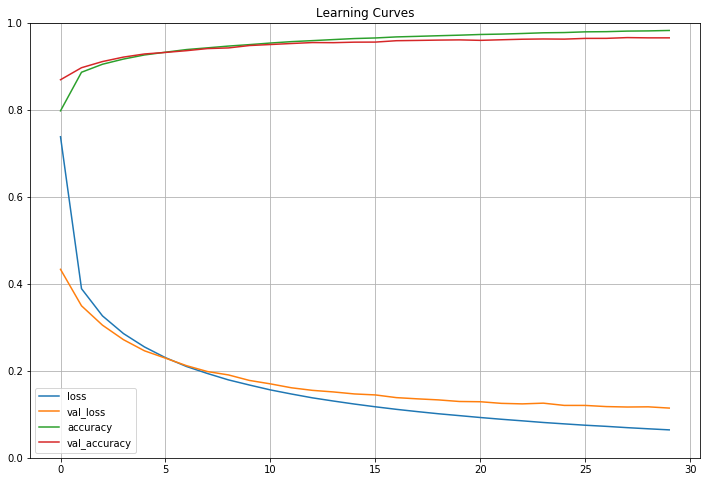

In [137]:
df_historial1=pd.DataFrame(model1.history.history)
df_historial1[['loss','val_loss','accuracy', 'val_accuracy']].plot(figsize=(12, 8),
                                                                  grid=True, 
                                                                  title="Learning Curves",
                                                                  ylim=(0,1));

#### Modelo 2: 300 Relu 200 Relu adam <a class="anchor" id="Modelo2"></a>

Arquitectura

In [138]:
model2 = keras.models.Sequential([keras.layers.Flatten(input_shape=[14, 14]),
                                keras.layers.Dense(300, activation="relu"),
                                keras.layers.Dense(100, activation="relu"),
                                keras.layers.Dense(10, activation="softmax")
                                ])

Resumen

In [139]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 196)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 300)               59100     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
Total params: 90,210
Trainable params: 90,210
Non-trainable params: 0
_________________________________________________________________


Compilo

In [140]:
model2.compile(loss="sparse_categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

Entreno <a class="anchor" id="Fit2"></a>

In [141]:
history2 = model2.fit(X_val_train, y_val_train, epochs=30,
                    validation_data=(X_val_test, y_val_test))

Epoch 1/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.4767 - accuracy: 0.8512 - val_loss: 0.1651 - val_accuracy: 0.9488
Epoch 2/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1382 - accuracy: 0.9569 - val_loss: 0.1304 - val_accuracy: 0.9601
Epoch 3/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0918 - accuracy: 0.9707 - val_loss: 0.1199 - val_accuracy: 0.9640
Epoch 4/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0756 - accuracy: 0.9770 - val_loss: 0.1193 - val_accuracy: 0.9647
Epoch 5/30
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0582 - accuracy: 0.9807 - val_loss: 0.1290 - val_accuracy: 0.9645
Epoch 6/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0450 - accuracy: 0.9864 - val_loss: 0.1307 - val_accuracy: 0.9642
Epoch 7/30
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0413 - accuracy: 0.9868 - val_loss: 0.1417 - val_accuracy:

Learning curve <a class="anchor" id="Curve2"></a>

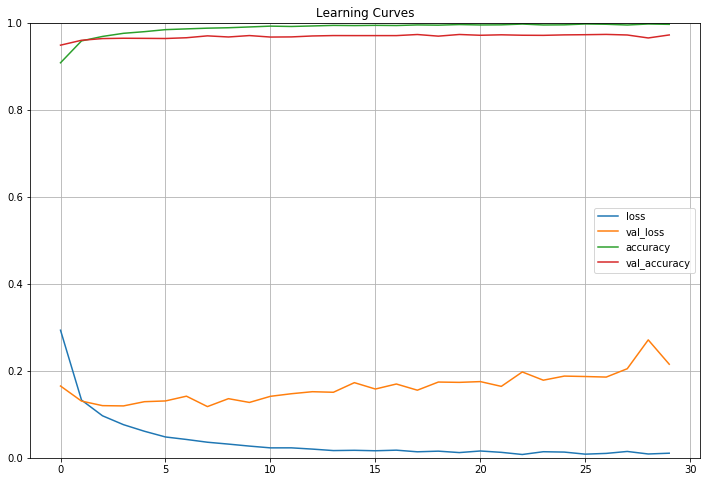

In [142]:
df_historial2=pd.DataFrame(model2.history.history)
df_historial2[['loss','val_loss','accuracy', 'val_accuracy']].plot(figsize=(12, 8),
                                                                  grid=True, 
                                                                  title="Learning Curves",
                                                                  ylim=(0,1));

### Seleccion final de modelo y entrenamiento con todos los datos (X_train, y_train)  <a class="anchor" id="SeleccionFinal"></a>

De acuerdo a los resultados anteriores, se decide elegir el modelo de red neuronal con dos capas ocultas de 300 y 100 neuronas, con funcion de activacion relu, la capa de salida con softmax y el optimizer ADAM. <a class="anchor" id="ModeloFinal"></a>

Arquitectura

In [11]:
model_final = keras.models.Sequential([keras.layers.Flatten(input_shape=[14, 14]),
                                keras.layers.Dense(300, activation="relu"),
                                keras.layers.Dense(100, activation="relu"),
                                keras.layers.Dense(10, activation="softmax")
                                ])

Resumen

In [12]:
model_final.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               59100     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 90,210
Trainable params: 90,210
Non-trainable params: 0
_________________________________________________________________


Compilo

In [13]:
model_final.compile(loss="sparse_categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

Entrenamiento

In [151]:
tf.config.run_functions_eagerly(True)

In [14]:
history_final = model_final.fit(X_train_best, y_train, epochs=30)

Epoch 1/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4331 - accuracy: 0.8676
Epoch 2/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1342 - accuracy: 0.9584
Epoch 3/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0914 - accuracy: 0.9713
Epoch 4/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0683 - accuracy: 0.9770
Epoch 5/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0562 - accuracy: 0.9816
Epoch 6/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0430 - accuracy: 0.9856
Epoch 7/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0367 - accuracy: 0.9883
Epoch 8/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0297 - accuracy: 0.9905
Epoch 9/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0275 - accuracy: 0.9912
Epoch 10/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.023

Curva de accuracy-loss <a class="anchor" id="Accuracy-Final"></a>

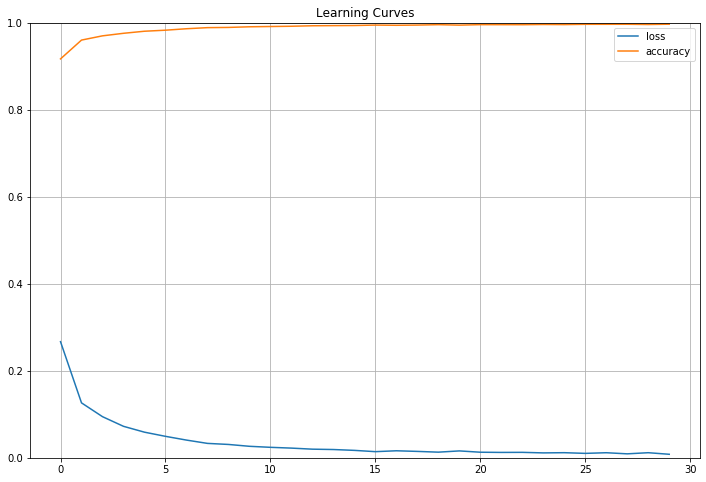

In [15]:
df_historial_final=pd.DataFrame(model_final.history.history)
df_historial_final[['loss','accuracy']].plot(figsize=(12, 8),
                                                                  grid=True, 
                                                                  title="Learning Curves",
                                                                  ylim=(0,1));

### Prediccion de resultados sobre las nuevas observaciones (X_test) <a class="anchor" id="Prediccion"></a> <a class="anchor" id="Predi1"></a>

In [16]:
predicciones=model_final.predict_classes(X_test_best)
predicciones

C:\Users\Mateio\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 9, 4, ..., 5, 9, 7], dtype=int64)

Guardo el resultado en el formato requerido  <a class="anchor" id="Guarda-npy">

In [17]:
np.save('Comba_2',predicciones)

### Guardar el modelo de produccion   <a class="anchor" id="Guarda-modelo">

In [157]:
model_final.save('Produccion_2')

INFO:tensorflow:Assets written to: Produccion_2\assets
